In [11]:
import os
import numpy as np
import pandas as pd
import dask
import dask.array as da
import dask.dataframe as dd

from hist import Hist

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [258]:
matplotlib.rcParams['savefig.dpi'] = 180
matplotlib.rcParams['figure.dpi'] = 180

In [4]:
import multiprocessing.popen_spawn_posix
from dask.distributed import Client, LocalCluster

#cluster = LocalCluster(n_workers=6, 
#                       threads_per_worker=1,
#                       memory_limit='5Gb')
#client = Client(cluster)

dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
client = Client(scheduler_file='/global/cscratch1/sd/cwalter/dask-mpi/scheduler.json')

client

Client Scheduler: tcp://10.128.0.148:45761 Dashboard: /user/cwalter/cori-shared-node-cpu/proxy/10.128.0.148:43253/status,Cluster Workers: 79 Cores: 79 Memory: 1.25 TB


In [38]:
scratch= os.environ["SCRATCH"]
#scratch = '/Users/walter/LSST/work'

#selected=['id', 'mag_r', 'g1', 'g2', 'e1','e2']
selected = ['id', 'mag_r', 'z', 'ra', 'dec', 'g1', 'g2']

#df = pd.read_parquet('shear-matched.parquet')#.dropna()
#df = dd.read_parquet(f'{scratch}/parquet-cosmoDC2/shear-cosmoDC2-*.parquet', columns=selected)
#df = dd.read_parquet(f'{scratch}/parquet-skysim-small/*.parquet', columns=selected, engine='pyarrow')
df = dd.read_parquet(f'{scratch}/parquet-skysim/*.parquet', columns=selected, engine='pyarrow')
#df = dd.read_parquet(f'{scratch}/skysim-sampled', columns=selected, engine='pyarrow')
df = df.persist()

print('Columns:', df.columns.values, '#Rows:', df.z.size.compute()/1e9)

Columns: ['id' 'mag_r' 'z' 'ra' 'dec' 'g1' 'g2'] #Rows: 6.263019986


In [39]:
%%script false

scratch= os.environ["SCRATCH"]

selected=['galaxy_id', 'mag_r', 'redshift_true', 'ra', 'dec', 'shear_1', 'shear_2']
rename_map ={'galaxy_id':'id', 'mag_r':'mag_r', 'redshift_true':'z', 'ra':'ra', 'dec':'dec', 'shear_1':'g1', 'shear_2':'g2'}

df = dd.read_parquet(f'/global/cfs/cdirs/lsst/shared/xgal/cosmoDC2/cosmoDC2_v1.1.4_parquet/*',columns=selected, engine='pyarrow')
df = df.rename(columns=rename_map)
df = df.query('mag_r < 29')
print('Columns:', df.columns.values, '#Rows:', df.ra.size.compute()/1e9)

In [40]:
print(f'g1 mean = {df.g1.mean().compute():.6f}')
print(f'g2 mean = {df.g2.mean().compute():.6f}')

g1 mean = 0.000453
g2 mean = -0.000039


In [41]:
def multiple_histogram_1d(series, bins, lower, upper, label='x-axis'):
    
    h = Hist.new.Reg(bins, lower, upper, name=label).Double()
    h.fill(series)
    return h

def hist_dask(series, bins, lower, upper):
    return series.map_partitions(multiple_histogram_1d, bins, lower, upper).compute().sum()

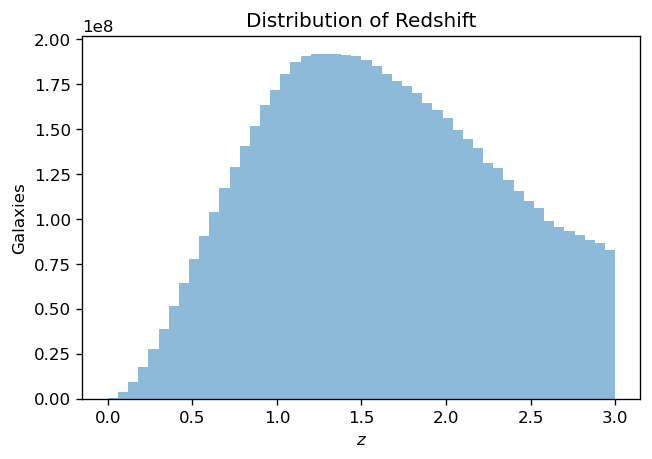

In [42]:
hist_dask(df.z, 50, 0, 3).plot(histtype='fill', alpha=0.5)

plt.title('Distribution of Redshift')
plt.xlabel(r'$z$')
plt.ylabel(r'Galaxies');

In [43]:
from hist import Hist

class dask_profile:
    
    def __init__(self, df, x_variable, y_variable, bins, lower, upper):   
        answer = df.map_partitions(dask_profile.multiple_histogram_profile, x_variable, y_variable, bins, lower, upper).compute().sum()
        summed = answer.view()
        
        self.centers = answer.axes.centers[0]
        self.mean = summed.value
        self.error_on_mean = np.sqrt(summed.variance/summed.count)  
    
    @staticmethod
    def multiple_histogram_profile(df, x_variable, y_variable, bins, lower, upper):

        df_x = df.filter([x_variable]).squeeze()
        df_y = df.filter([y_variable]).squeeze()
    
        h = Hist.new.Reg(bins, lower, upper).Mean()
        h.fill(df_x, sample=df_y)
        return h
    
    def plot(self):
        plt.errorbar(x=self.centers, y=self.mean, yerr=self.error_on_mean, fmt = '.', markersize=3)

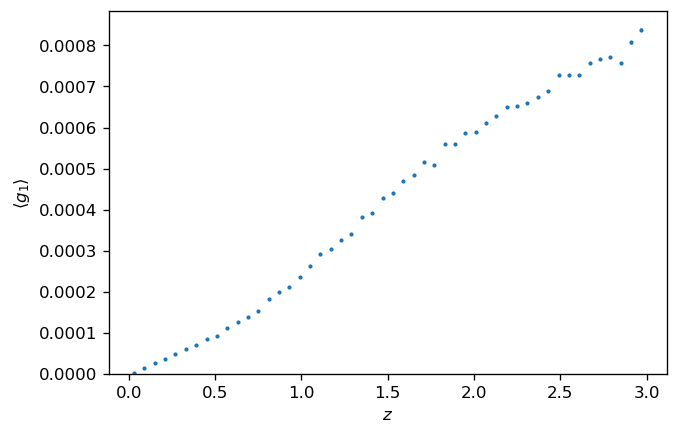

In [44]:
dask_profile(df, 'z', 'g1', 50, 0, 3).plot()

plt.ylim(bottom=0)
plt.xlabel(r'$z$')
plt.ylabel(r'$\langle g_1 \rangle$');

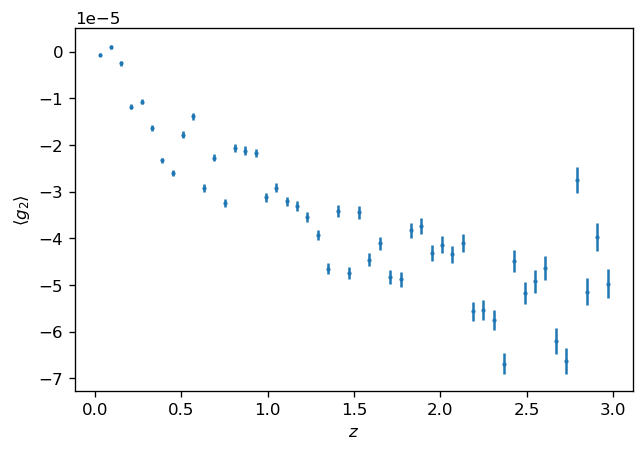

In [45]:
dask_profile(df, 'z', 'g2', 50, 0, 3).plot()

#plt.ylim(bottom=0)
plt.xlabel(r'$z$')
plt.ylabel(r'$\langle g_2 \rangle$');

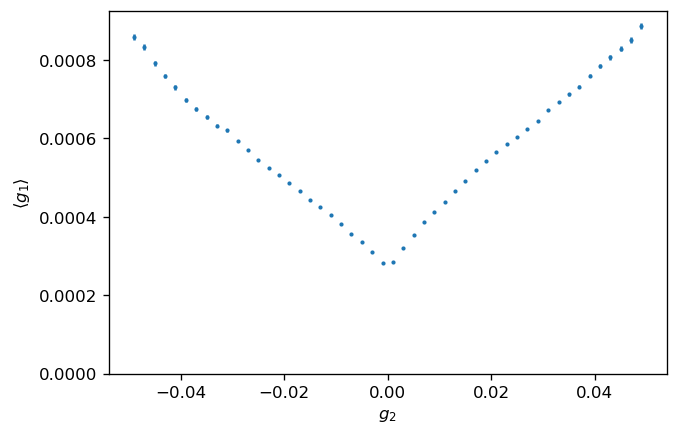

In [46]:
dask_profile(df, 'g2', 'g1', 50, -0.05, 0.05).plot()

plt.ylim(bottom=0)
plt.xlabel(r'$g_2$')
plt.ylabel(r'$\langle g_1 \rangle$');

Text(0, 0.5, '$\\langle g_1\\rangle and \\langle g^{\\prime}_1 \\rangle$')

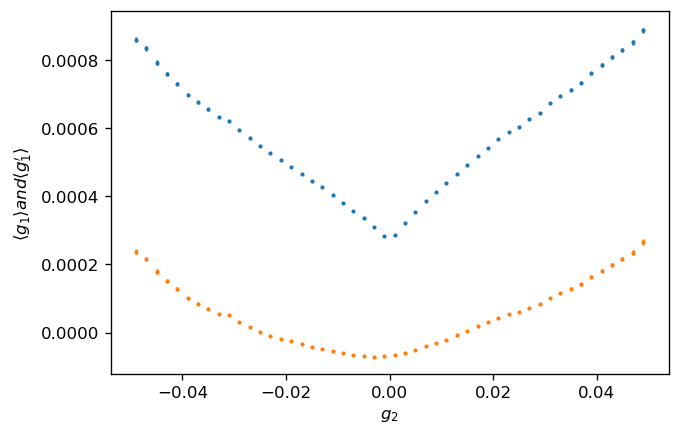

In [47]:
slope_g1 = .00085/3 # <g1>/z
slope_g2 = -7e-5/3 # <g2>/z

df['g1_prime'] = df.g1 - slope_g1*df.z
df['g2_prime'] = df.g2 - slope_g2*df.z

dask_profile(df, 'g2', 'g1', 50, -0.05, 0.05).plot()
dask_profile(df, 'g2', 'g1_prime', 50, -0.05, 0.05).plot()

plt.xlabel(r'$g_2$')
plt.ylabel(r'$\langle g_1\rangle and \langle g^{\prime}_1 \rangle$')

In [51]:
import hvplot.dask
import hvplot.pandas

num_bins = 50

#x_range = np.linspace(45, 80, num_bins)
#y_range = np.linspace(-45, -24, num_bins)

x_range = np.linspace(-.04, .04, num_bins)
y_range = np.linspace(-.04, .04, num_bins)

df['x'] = df.g1.map_partitions(pd.cut, bins=x_range, labels=y_range[:-1])
df['y'] = df.g2.map_partitions(pd.cut, bins=y_range, labels=x_range[:-1])

grouped = df.groupby(['x', 'y']).g1.count().compute()
map = grouped.unstack()
map.hvplot.heatmap(y='index', x='columns', width=800, height=500, rot =70, xformatter='%0.3f', logz=True)

:HeatMap   [columns,index]   (value)

In [52]:
def multiple_histogram_2d(df):
    
    h = Hist.new.Reg(3, 0, 90, name='RA').Reg(3, -90, 0, name='Dec').Reg(50, 0, 3, name='Redshift').Mean()
    h.fill(df.ra, df.dec, df.z, sample=df.g1)
    return h

blocks = df.map_partitions(multiple_histogram_2d).compute().sum()

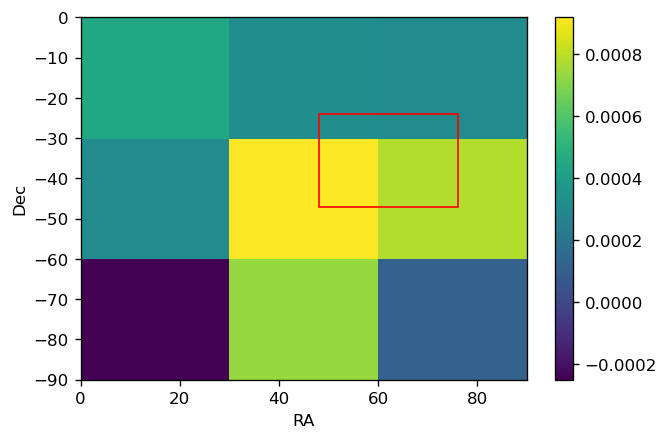

In [343]:
mean_2d = blocks.project('RA','Dec').view().value
x = blocks_2d.axes[0].edges
y = blocks_2d.axes[1].edges
plt.pcolormesh(x, y, mean_2d.T)

plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')

import matplotlib.patches as patches
currentAxis = plt.gca()
cosmoDC2 = patches.Rectangle((48,-47),28,23,linewidth=1,edgecolor='r',facecolor='none')
currentAxis.add_patch(cosmoDC2);

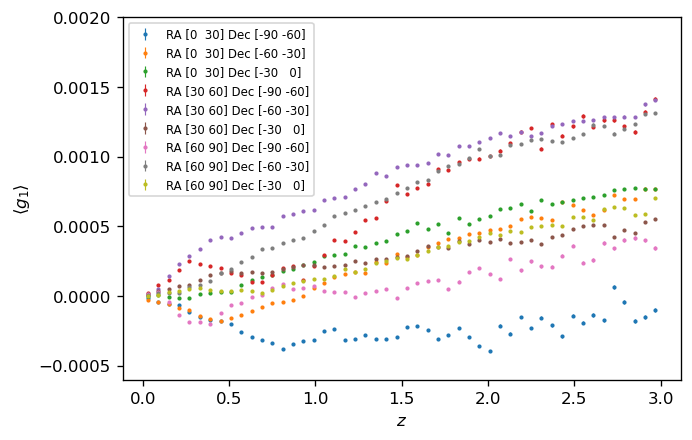

In [341]:
ra_dec_axes = blocks[:,:,0].axes

for index in np.ndindex(3, 3):

    bin = ra_dec_axes.bin(*index)
    label = f'RA [{bin[0][0]:<2.0f} {bin[0][1]:>2.0f}] Dec [{bin[1][0]:<3.0f} {bin[1][1]:>3.0f}]'
    
    patch = blocks[index[0], index[1], :]
    centers = patch.axes.centers[0]
    mean = patch.view().value
    error_on_mean = np.sqrt(patch.view().variance/patch.view().count) 
    
    plt.errorbar(x=centers, y=mean, yerr=error_on_mean, fmt = '.', markersize=3, elinewidth=.7, label=label)
    
plt.ylim(bottom=-.0006, top=.0020);
plt.legend(prop={'size': 7})
plt.xlabel(r'$z$')
plt.ylabel(r'$\langle g_1 \rangle$');

In [71]:
%%script false

import math 

reduced_shear = mean_2d
magnitude = np.abs(mean_2d)
phi = math.pi/2

currentAxis = plt.gca()
cosmoDC2 = patches.Rectangle((48,-47),28,23,linewidth=1,edgecolor='r',facecolor='none')
currentAxis.add_patch(cosmoDC2)

plt.quiver(x_centers, y_centers, magnitude*np.cos(phi), magnitude*np.sin(phi), pivot='mid', width=.00500)
plt.xlabel('RA')
plt.ylabel('Dec')

In [70]:
%%script false

matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.dpi'] = 150

selected = df.query('.009 < g2 < 0.011')
selected.g1.size.compute()

selected.g1.hist(bins=10, grid=True, histtype='step')
plt.title('.009 < g2 < 0.011')
plt.yscale('log')
plt.xlabel('g1')

In [37]:
client.restart();

In [28]:
client.cancel(df)